In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
from lib.metrics import create_dir
from lib.evaluate import test_model
from lib.load_data import get_data

import cv2
from skimage import io
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

import matplotlib.font_manager
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.models import Model, model_from_json

print('TensorFlow version: {version}'.format(version=tf.__version__))
print('Keras version: {version}'.format(version=tf.keras.__version__))
print('Eager mode enabled: {mode}'.format(mode=tf.executing_eagerly()))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

2023-06-12 05:29:42.352528: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 05:29:42.973409: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mpanta1/.conda/envs/tf_gpu/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


TensorFlow version: 2.12.0
Keras version: 2.12.0
Eager mode enabled: True
Num GPUs Available:  1
Num CPUs Available:  1


## Load dataset for interpretation

In [8]:
img_height = 256
img_width = 256

root_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir+os.sep+os.pardir )
path_test_levee = os.path.join(root_dir,  "datasets", "test")


test_images_levee = sorted(next(os.walk(path_test_levee + "/images"))[2])

X_test_levee, Y_test_levee = get_data(test_images_levee, path_test_levee, img_height, img_width, train=True)

(51, 256, 256, 3)
Getting and resizing images ... 


100%|██████████| 51/51 [00:41<00:00,  1.23it/s]

Done!
(51, 256, 256, 3)


In [3]:
!nvidia-smi

Tue Jun 13 00:06:28 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe           Off| 00000000:08:00.0 Off |                    0 |
| N/A   68C    P0              273W / 300W|  80692MiB / 81920MiB |     12%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

## Load model

In [9]:
def load_trained_model(model_name):
    root_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir)
    model_path = os.path.join(root_dir,  "models", str(model_name), "best_model.h5")
    tf.keras.backend.clear_session()
    best_model = tf.keras.models.load_model(model_path, compile=False)
    %time
    
    print(f'=========Loaded {model_name}===========')
    
    return best_model

In [10]:
model = load_trained_model("Baseline_Normal_IEEE_bce_dice_loss_new")

2023-06-12 05:30:33.343323: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78923 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:88:00.0, compute capability: 8.0


CPU times: user 12 µs, sys: 4 µs, total: 16 µs
Wall time: 30.5 µs
=========Loaded Baseline_Normal_IEEE_bce_dice_loss_new===========


## Filter Visualization Technique

In [11]:
layer_outputs = [layer.output for layer in model.layers[:]] 
for i in range(len(layer_outputs)):
    print('{} layer: {}'.format(i, layer_outputs[i]))
idx = [0, 9, 250, 447, 802]
layer_outputs2 = []
for temp in idx:
    layer_outputs2.append(layer_outputs[temp])

0 layer: KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
1 layer: KerasTensor(type_spec=TensorSpec(shape=(None, 262, 262, 3), dtype=tf.float32, name=None), name='conv1_pad/Pad:0', description="created by layer 'conv1_pad'")
2 layer: KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 64), dtype=tf.float32, name=None), name='conv1_conv/BiasAdd:0', description="created by layer 'conv1_conv'")
3 layer: KerasTensor(type_spec=TensorSpec(shape=(None, 130, 130, 64), dtype=tf.float32, name=None), name='pool1_pad/Pad:0', description="created by layer 'pool1_pad'")
4 layer: KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='pool1_pool/MaxPool:0', description="created by layer 'pool1_pool'")
5 layer: KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='conv2_block1_preact_bn/FusedBatchNormV3:0', descripti

IndexError: list index out of range

1/1 [==============================] - 8s 8s/step


/tmp/ipykernel_36824/34387022.py:24: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(display_grid, aspect='auto', cmap='viridis')
/tmp/ipykernel_36824/34387022.py:15: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
/tmp/ipykernel_36824/34387022.py:18: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


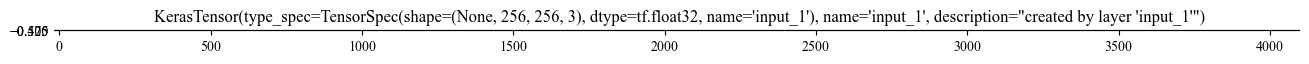

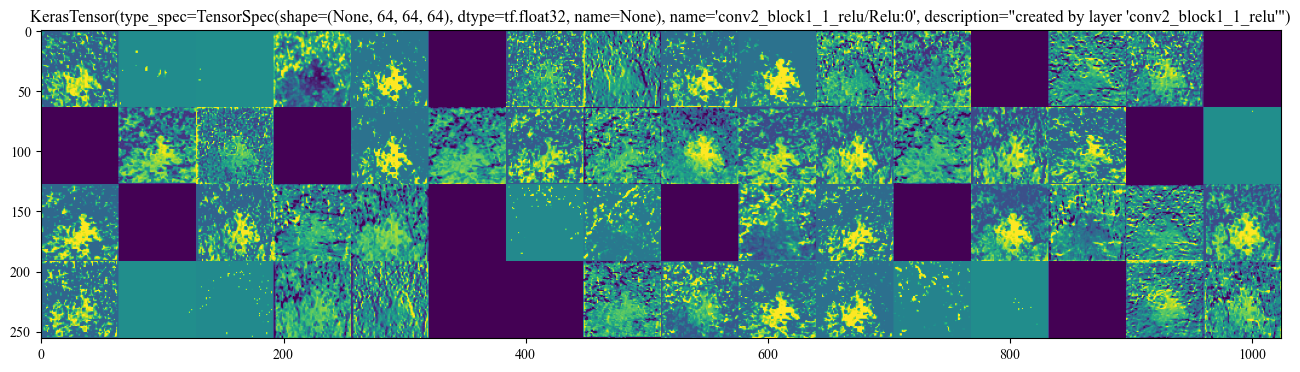

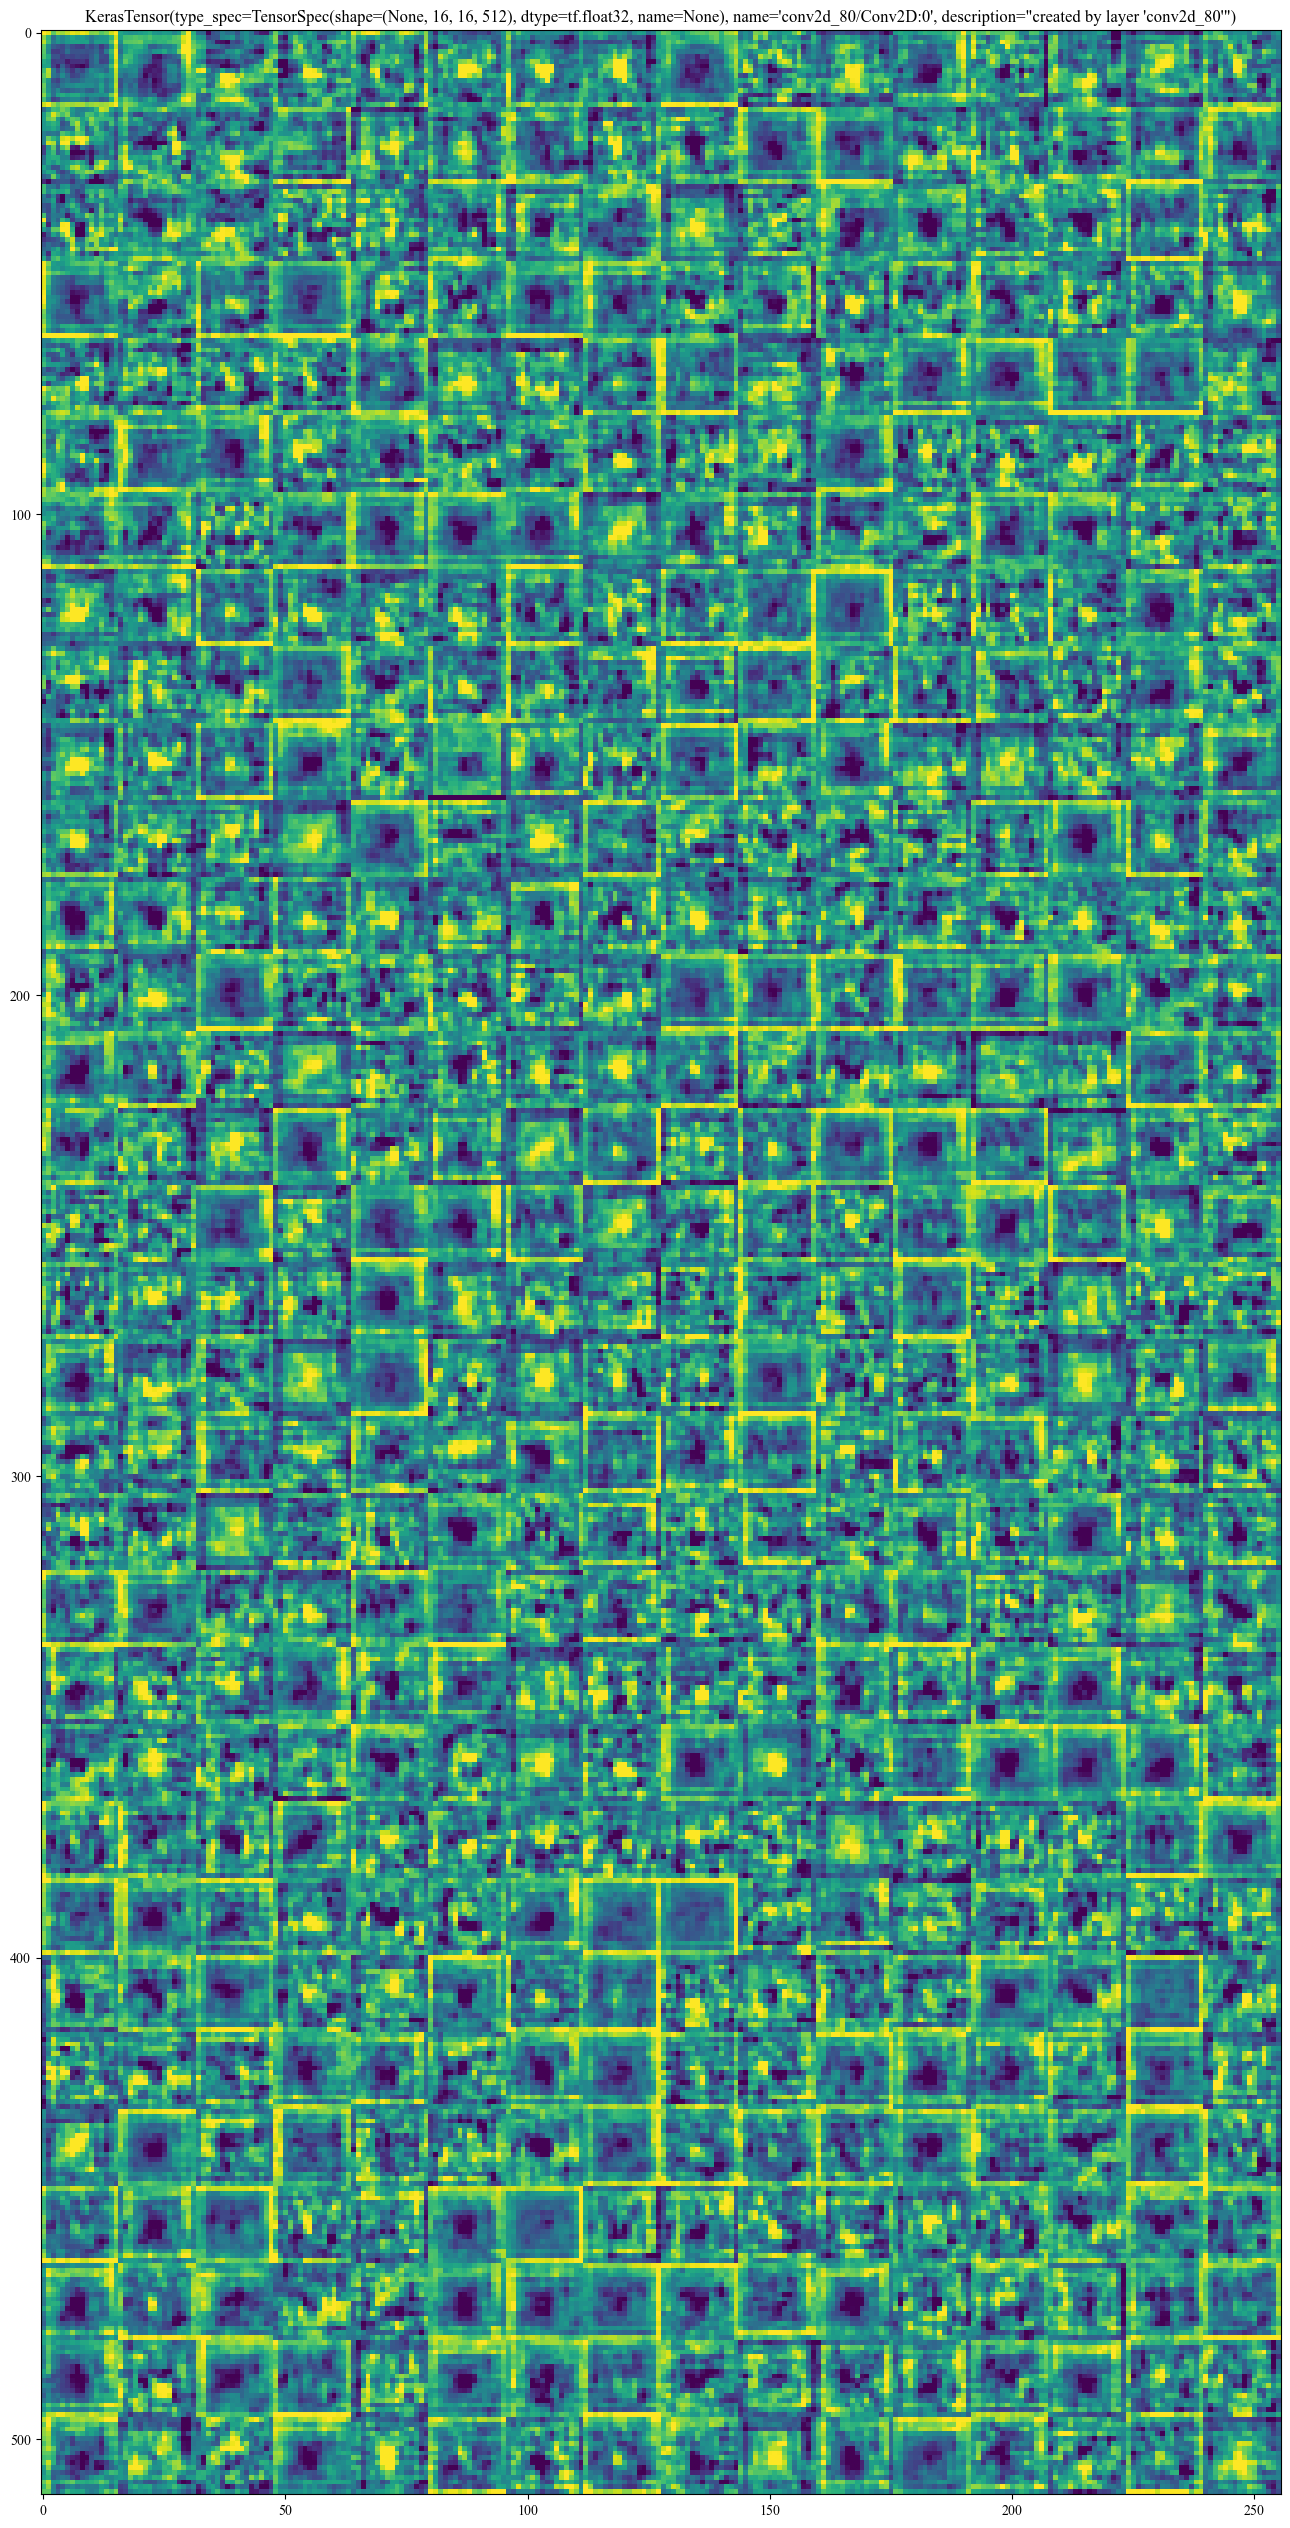

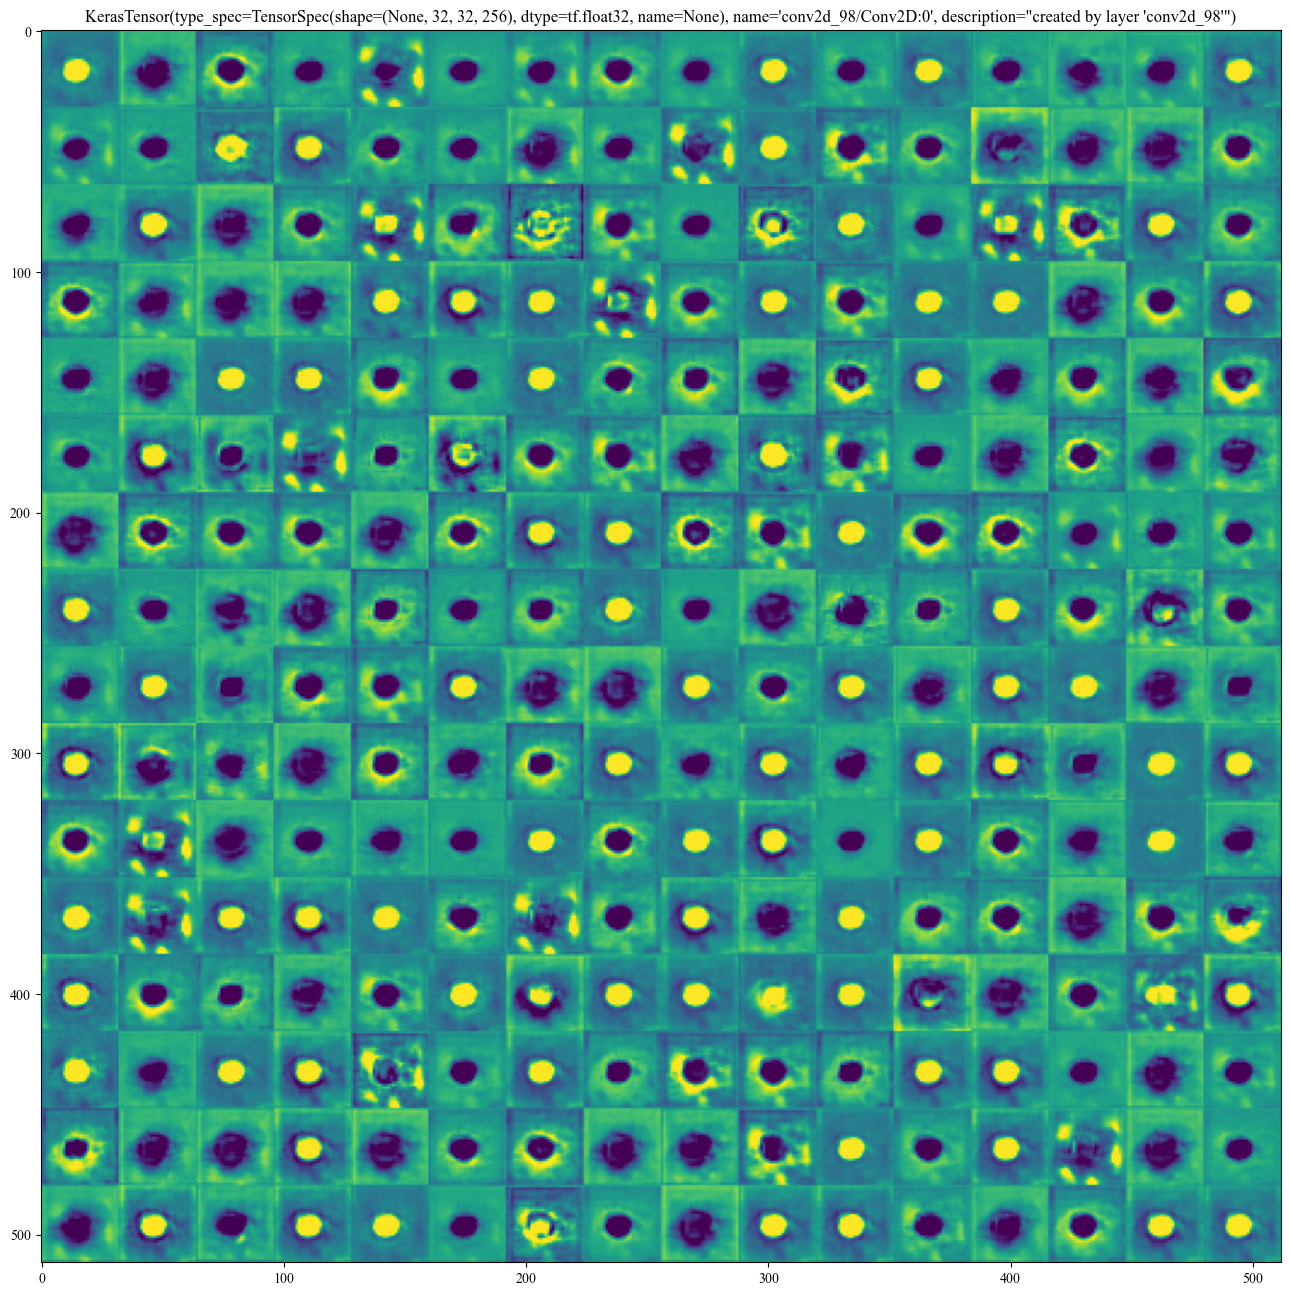

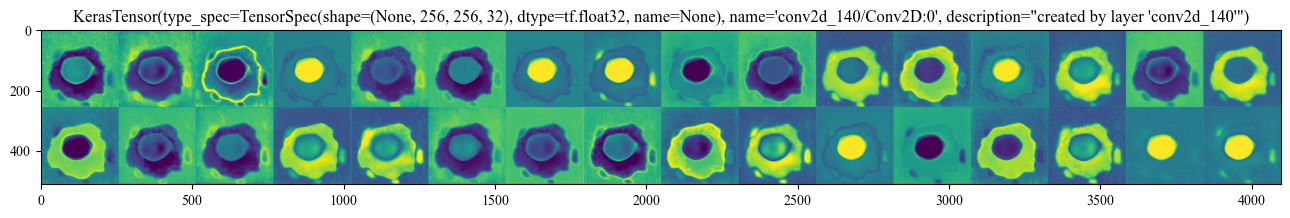

In [16]:
activation_model = Model(inputs=model.input, outputs=layer_outputs2)
activations = activation_model.predict(X_test_levee[:1])

#Visualization
images_per_row = 16
for layer_name, layer_activation in zip(layer_outputs2, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(str(layer_name))
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Class Activation Map Based technique

In [27]:
from tf_keras_vis.activation_maximization import ActivationMaximization
layer_name = 'visualized_layer' # The target layer that is kept the last layer of our model.

def model_modifier(current_model):
    target_layer = current_model.get_layer(name=layer_name)
    new_model = Model(inputs=current_model.inputs, outputs=target_layer.output)
    new_model.layers[-1].activation = tf.keras.activations.linear
    return new_model

def loss(output):
     return output[filter_number]

In [28]:
activation_maximization = ActivationMaximization(model, model_modifier)

In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(14,14))
for i in range(0, 10):
    filter_number = i
    activation = activation_maximization(loss)
    image = activation[0].astype(np.uint8)
    ax[i].xaxis.set_visible(False)
    ax[i].yaxis.set_visible(False)
    ax[i].set_title(str(i))
    ax[i].imshow(image)

## Gradient based class activation maps

Using Grad-CAM, we can visually validate where out network is looking, verifying that it is indeed looking at the correct patterns in the image and activatingg around those patterns.

### How does GRAD-CAM work?
1. Finds the final convolution layer in the network
2. Examins the gradient information flow in to that layer

In [30]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

In [31]:
gradcam = GradcamPlusPlus(model, model_modifier=ReplaceToLinear(), clone=True)
cam = gradcam(CategoricalScore(CATEGORICAL_INDEX), SEED_INPUT)

NameError: name 'CATEGORICAL_INDEX' is not defined

In [ ]:
plt.imshow(SEED_INPUT_IMAGE)
heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
plt.imshow(heatmap, cmap='jet', alpha=0.5) # overlay